# 状態空間モデル

## 背景
- 状態空間モデルは非常に幅広い概念で、もともとは物理システムの記述に使われていた
- 1960年代、カルマンによって制御工学での利用が進み、1970年代には赤池により統計科学への応用された
- 1990年代では金融データに対する応用が盛んになり、2000年以降、ボラティリティの推定、債券価格やコモディティ価格のモデリングなどでモデルの研究が進んだ


## 状態空間モデルの特性
- 状態空間モデルは、ほとんどの時系列モデルを表現できる汎用性の高いモデル
    - もちろんAR、MA、ARMA、ARIMAなども表現可能
- 隠れ状態を推定する<font color="red">状態方程式</font>と、観測値を推定する<font color="red">観測方程式</font>からなる
- カルマンフィルターをはじめとした、様々なモデルとそれに対応した数値計算アルゴリズムが知られており、多くの分野に応用されている
- 時系列予測をさまざまな要因分解の結果として行なえるため、時変パラメータの解釈や可視化が容易で、売上に対する広告影響の構造把握などができる

## 利点
- 適切な状態空間モデルを用いることで、観測できないが状態の推定が可能
- 観測ノイズと状態ノイズを分離できる
- 欠損値があっても、その時点での状態を推定することで補完ができるため、特に問題にならない

## 状態空間モデルの目的
<font color="red">隠れ状態の推定</font>
- 状態の推定には以下の3種類存在
    - 予測：過去の観測値を用いて、未来の状態を推定
    - フィルタリング：当該時点の観測値を用いて、当該時点の状態を推定
        - 予測結果のずれを、観測値に基づいて修正する作業
    - 平滑化：未来の観測値を用いて、過去の状態を推定
        - 全てのデータを使った状態の修正であり、過去のデータのみを使うよりも正確な推定が可能
        - キャンペーンの効果を振り返るときなど、フィードバックや知見獲得を目的として行われることが多い作業


## 状態空間モデルで抑えるべきポイント
1. 事前にパラメータを決める方法（状態方程式と観測方程式）: <font color="red">05_param_estimate 参照</font>
1. パラメタを使って、カルマンフィルタを実行し、「状態」を推定する方法: <font color="red">05_kalman_filter 参照</font>

## 以下は statsmodels による状態空間モデルの[example](https://github.com/statsmodels/statsmodels/blob/a5a6c44674d76c49944ca76d8ff8cd747e91be3a/examples/notebooks/statespace_fixed_params.ipynb)

In [1]:
%matplotlib inline

In [3]:
from importlib import reload
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from pandas_datareader.data import DataReader

### 使用するデータ
CPIAPPNS (Consumer Price Index for All Urban Consumers: Apparel in U.S. City Average)

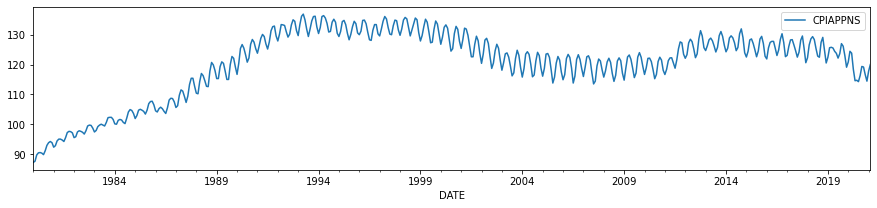

In [4]:
endog = DataReader('CPIAPPNS', 'fred', start='1980').asfreq('MS')
endog.plot(figsize=(15, 3));

### Hodrick-Prescott filter: トレンドとサイクル（周期成分）の分解手法
元の時系列 $(x_1, x_2, \cdots, x_T)$ に対して、以下の数式を最小にする系列 $(y_1, y_2, \cdots, y_T)$ を得る手法。<br>
$\sum_{t=1}^T (x_t - y_t)^2 + \lambda \sum_{t=2}^{T-1} (\Delta y_{t+1} - \Delta y_t)^2$　ただし、$\Delta y_t = y_t - y_{t-1}$<br>
第1項は元の系列から乖離しない制約、第2項は得られる系列が滑らかである制約を表す。

### lltrend (Local linear trend) により状態空間モデルを構築
- 参照：https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.structural.UnobservedComponents.html
- local linear trend における $\sigma_\varepsilon^2, \sigma_\eta^2, \sigma_\zeta^2$ に制約を加えることにより、HPフィルタの出力が生成可能だということが知られている
     - 具体的には $\sigma_\varepsilon^2 / \sigma_\zeta^2 = \lambda, \sigma_\eta^2 = 0$
     - $\lambda$ はHPフィルタに関するパラメー
     - 月次データでは、$\lambda = 129,600$が推奨されているそう

In [12]:
# Run the HP filter with lambda = 129600
hp_cycle, hp_trend = sm.tsa.filters.hpfilter(endog, lamb=129600)

# The unobserved components model above is the local linear trend, or "lltrend", specification
mod = sm.tsa.UnobservedComponents(endog, 'lltrend')
print(mod.param_names)

['sigma2.irregular', 'sigma2.level', 'sigma2.trend']


### カルマンフィルタによるスムージング（平滑化）
- 引数にローカル線形トレンドに登場するパラメータを指定
    - パラメータは指定しているので fit メソッドによる最尤推定が不要
    - $\lambda=129,600$を満たすために、以下のように設定
        - $\sigma_\epsilon^2 = 1$
        - $\sigma_\eta^2 = 0$
        - $\sigma_\zeta^2 = 1 / 129,600$

In [21]:
res = mod.smooth([1., 0, 1. / 129600])
print(res.summary())

                        Unobserved Components Results                         
Dep. Variable:               CPIAPPNS   No. Observations:                  494
Model:             local linear trend   Log Likelihood               -2543.420
Date:                Mon, 22 Mar 2021   AIC                           5092.841
Time:                        16:26:21   BIC                           5105.436
Sample:                    01-01-1980   HQIC                          5097.786
                         - 02-01-2021                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     1.0000      0.010    102.423      0.000       0.981       1.019
sigma2.level              0      0.000          0      1.000      -0.000       0.000
sigma2.trend      7.716e-06 

### HPフィルタによるトレンドの推定値に対応する出力は平滑化した水準（$\mu_t$のこと） 

In [14]:
ucm_trend = pd.Series(res.level.smoothed, index=endog.index)

### 比較してみる
- HPフィルタの出力（トレンド推定値）と一致している

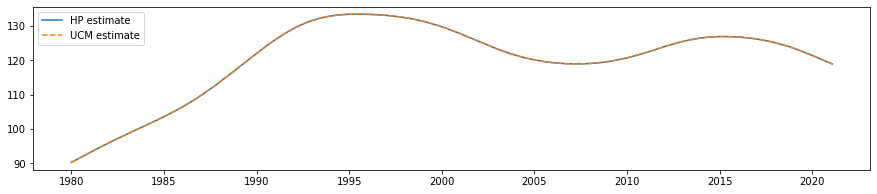

In [26]:
fig, ax = plt.subplots(figsize=(15, 3))

ax.plot(hp_trend, label='HP estimate')
ax.plot(ucm_trend, linestyle='--', label='UCM estimate')
ax.legend()

## 確率的に変動する季節性の導入
- HPフィルタと比較して状態空間モデルはより柔軟
- 今回のデータの季節性に着目すると、当初より季節性が増している
- 状態空間モデルでは、このような確率的に変動する季節性のコンポーネントの追加が可能

In [27]:
# Construct a local linear trend model with a stochastic seasonal component of period 1 year
mod = sm.tsa.UnobservedComponents(endog, 'lltrend', seasonal=12, stochastic_seasonal=True)
print(mod.param_names)

['sigma2.irregular', 'sigma2.level', 'sigma2.trend', 'sigma2.seasonal']


### 上記のようなパラメータの制約をしつつ、季節成分の分散を最尤法により推定

In [28]:
# Here we restrict the first three parameters to specific values
with mod.fix_params({'sigma2.irregular': 1, 'sigma2.level': 0, 'sigma2.trend': 1. / 129600}):
    # Now we fit any remaining parameters, which in this case
    # is just `sigma2.seasonal`
    res_restricted = mod.fit()

### 下記のようなやり方でも可能

In [29]:
res_restricted = mod.fit_constrained({'sigma2.irregular': 1, 'sigma2.level': 0, 'sigma2.trend': 1. / 129600})

### irregular, level, trendの分散は固定されている（推定されていない）ことが確認できる

In [30]:
print(res_restricted.summary())

                            Unobserved Components Results                            
Dep. Variable:                      CPIAPPNS   No. Observations:                  494
Model:                    local linear trend   Log Likelihood               -1348.104
                   + stochastic seasonal(12)   AIC                           2698.208
Date:                       Mon, 22 Mar 2021   BIC                           2702.384
Time:                               18:13:41   HQIC                          2699.849
Sample:                           01-01-1980                                         
                                - 02-01-2021                                         
Covariance Type:                         opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
sigma2.irregular (fixed)     1.0000     

### 比較のために、全てのパラメータを最尤法で推定してみる
- この場合、トレンドがHPフィルタの概念に一致しない

In [32]:
res_unrestricted = mod.fit()
print(res_unrestricted.summary())

                            Unobserved Components Results                            
Dep. Variable:                      CPIAPPNS   No. Observations:                  494
Model:                    local linear trend   Log Likelihood                -678.516
                   + stochastic seasonal(12)   AIC                           1365.031
Date:                       Mon, 22 Mar 2021   BIC                           1381.735
Time:                               18:19:39   HQIC                          1371.597
Sample:                           01-01-1980                                         
                                - 02-01-2021                                         
Covariance Type:                         opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  6.684e-10      0.034   1.95e-08      1

### 両者（パラメータ制約あり・なし）のトレンドと季節成分を拾ってみる

In [33]:
# Construct the smoothed level estimates
unrestricted_trend = pd.Series(res_unrestricted.level.smoothed, index=endog.index)
restricted_trend = pd.Series(res_restricted.level.smoothed, index=endog.index)

# Construct the smoothed estimates of the seasonal pattern
unrestricted_seasonal = pd.Series(res_unrestricted.seasonal.smoothed, index=endog.index)
restricted_seasonal = pd.Series(res_restricted.seasonal.smoothed, index=endog.index)

### トレンドをプロットして比較する
- 全パラメータを最尤推定すると（MLE w/ seasonal）、トレンドがギザギザしてしまう
- パラメータに制約を入れると（Fixed parameters w/ seasonal）、トレンドがHPフィルタの出力に一致
    - 適切なトレンドの抽出ができている

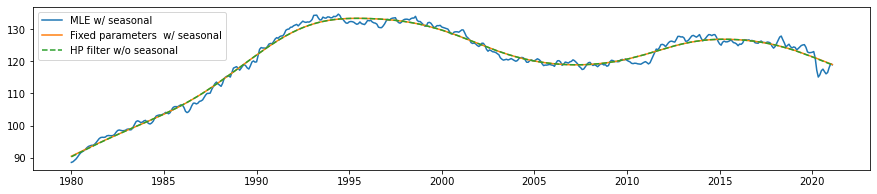

In [37]:
fig, ax = plt.subplots(figsize=(15, 3))

ax.plot(unrestricted_trend, label='MLE w/ seasonal')
ax.plot(restricted_trend, label='Fixed parameters  w/ seasonal')
ax.plot(hp_trend, linestyle='--', label='HP filter w/o seasonal')
ax.legend()

### 季節性（周期性）をプロットして比較する
- HP filter により抽出された周期性は汚い印象
- パラメータに制約を入れると、きれいに周期性を抽出できていることがわかる

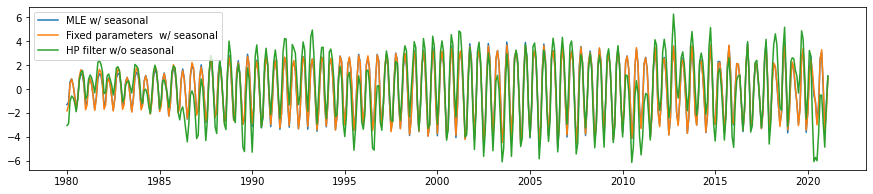

In [39]:
fig, ax = plt.subplots(figsize=(15, 3))

ax.plot(unrestricted_seasonal, label='MLE w/ seasonal')
ax.plot(restricted_seasonal, label='Fixed parameters  w/ seasonal')
ax.plot(hp_cycle, label='HP filter w/o seasonal')
ax.legend();

### HPフィルタの特性の確認用
周期性 = 元の時系列 - HPフィルタの出力　であることがわかる

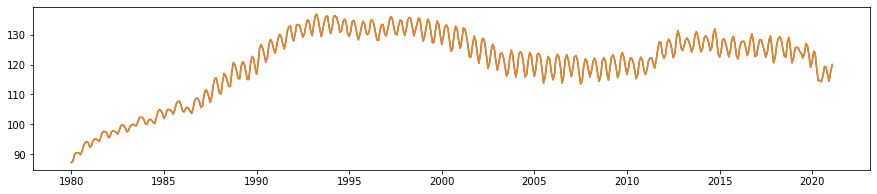

In [43]:
plt.figure(figsize=(15, 3))

plt.plot(hp_cycle+hp_trend)
plt.plot(endog)